In [1]:
import keras
import tensorflow as tf

Using TensorFlow backend.


In [2]:
import sys
import os
import datetime
print(sys.version)
print(keras.__version__)
print(tf.__version__)

3.6.0 (default, Jul 21 2017, 18:38:06) 
[GCC 4.8.4]
2.0.6
1.2.0


In [3]:
import matplotlib.pyplot as plt
import numpy as np

### Data preparation

In [4]:
from sklearn.model_selection import train_test_split 
def prepTest(sdirectory, tdirectory, test_size=0.20):
    for c in os.listdir(sdirectory):
        files = os.listdir(os.path.join(sdirectory,c))
        train,test = train_test_split(files, test_size = test_size)
        for file in train:
            os.renames(os.path.join(sdirectory,c,file), os.path.join(tdirectory,'train',c,file))
        for file in test:
            os.renames(os.path.join(sdirectory,c,file), os.path.join(tdirectory,'validate',c,file))

In [5]:
#prepTest('train','data') #бьет папочку на train и test

In [5]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

batch_size = 64

train_datagen = ImageDataGenerator(
        rescale=1./255,
        #shear_range=0.5,
        #zoom_range=[0.2,1.5],
        rotation_range=15,
        horizontal_flip=True)#,
        #width_shift_range=0.3,
        #height_shift_range=0.3,
        #fill_mode='nearest')

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        '../data/train',  # this is the target directory
        target_size=(96, 96),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        '../data/validate',
        target_size=(96, 96),
        batch_size=batch_size,
        class_mode='categorical')

Found 4000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


In [6]:
predict_datagen = ImageDataGenerator(rescale=1./255)
predict_generator = predict_datagen.flow_from_directory(
        '../validate',
        target_size=(96,96),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 3000 images belonging to 1 classes.


In [7]:
class PlotLosses(keras.callbacks.Callback):
    from IPython.display import clear_output
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        from IPython.display import clear_output
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        
        clear_output(wait=True)
        f, (ploss, pacc) = plt.subplots(1,2)
        f.set_figwidth(12)
        ploss.plot(self.x, self.losses, label="loss")
        ploss.plot(self.x, self.val_losses, label="val_loss")
        ploss.legend()
        pacc.plot(self.x, self.acc, label="acc")
        pacc.plot(self.x, self.val_acc, label="val_acc")
        pacc.legend()
        plt.show();
        
plot_losses = PlotLosses()

### Model

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import RMSprop, Nadam, Adam
from keras.callbacks import LearningRateScheduler

model = Sequential()
model.add(Conv2D(48, (3, 3), input_shape=(96, 96, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#model.add(Conv2D(128, (3, 3), padding='same'))
#model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))

#model.add(Dropout(0.25))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
#model.add(Dense(128))
#model.add(Activation('relu'))
#model.add(Dense(64))
#model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.002),
              metrics=['accuracy'])

#### LearningRateScheduler

In [9]:
# LearningRateScheduler
def step_decay(epoch):
    import math
    initial_lrate = 0.0015
    drop = 0.75
    epochs_drop = 25.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    print(lrate)
    return lrate

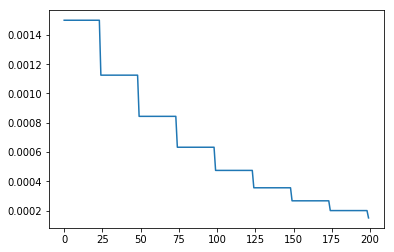

In [111]:
plt.plot([step_decay(i) for i in range(200)])
plt.show()

#### Fit Model

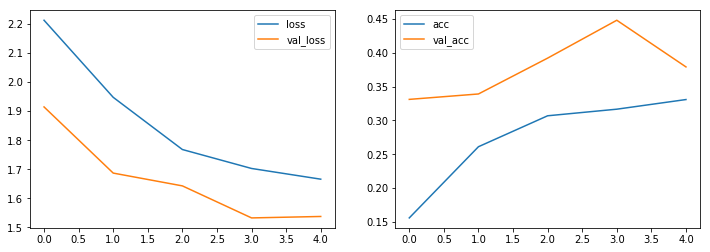

63/62 [==============================] - 10s - loss: 1.6658 - acc: 0.3304 - val_loss: 1.5375 - val_acc: 0.3790


In [10]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=4000 / batch_size,
        epochs=5,
        validation_data=validation_generator,
        callbacks=[plot_losses],# LearningRateScheduler(step_decay)],
        validation_steps=1000 / batch_size)

In [29]:
model.save(os.path.join('models',str(datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S'))))

ImportError: `save_model` requires h5py.

In [20]:
import h5py

### Старые картинки

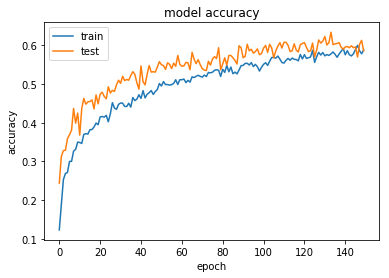

In [152]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

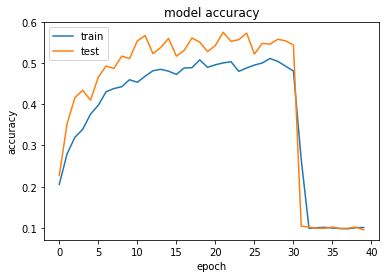

In [10]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

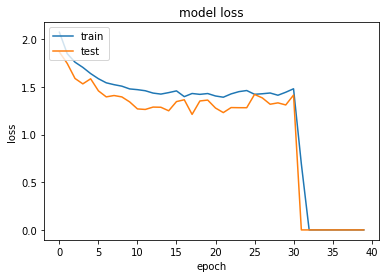

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Prediction

In [34]:
predicted = model.predict_generator(predict_generator, 3000 / batch_size)

In [35]:
predicted

array([[  4.65139965e-05,   1.10356230e-13,   4.02193809e-17, ...,
          1.20932358e-18,   9.99953508e-01,   1.56857347e-10],
       [  1.29900930e-14,   1.45634122e-05,   7.66267258e-11, ...,
          1.60638156e-05,   7.91739399e-15,   1.17273669e-09],
       [  9.10577774e-02,   3.53199596e-07,   2.42642127e-03, ...,
          3.47591896e-14,   8.69445980e-01,   3.70694250e-02],
       ..., 
       [  6.61760566e-08,   4.27233696e-01,   4.37019509e-07, ...,
          3.31239663e-02,   1.81758408e-09,   8.93652512e-08],
       [  6.58557892e-01,   3.13775331e-01,   7.16850907e-03, ...,
          1.47050368e-05,   1.36853906e-03,   1.76123101e-02],
       [  9.45869029e-01,   3.44617030e-04,   3.05795438e-05, ...,
          2.29631052e-08,   5.14466800e-02,   2.29347777e-03]], dtype=float32)

In [36]:
import re
import pandas as pd
output = pd.DataFrame({
            'uid': [re.match(r'validate/(.*).png',f).group(1) for f in predict_generator.filenames],
            'classes': [list(train_generator.class_indices)[np.argmax(p)] for p in predicted]}) \
        .reindex_axis(['uid','classes'],axis=1) \
        .set_index('uid')

In [37]:
print(output.shape)
output.head(3)

(3000, 1)


,classes
uid,
ship-file0280,ship
horse-file0247,horse
truck-file0296,ship


In [38]:
submission = pd.read_csv('dl_lab_pictures.csv',sep='\t', index_col='uid')

In [39]:
submission['classes']=output['classes']
submission = submission.reset_index()
print(submission.shape)
submission.head(3)

(3000, 3)


,uid,index,classes
0,airplane-file0000,0,airplane
1,airplane-file0001,1,airplane
2,airplane-file0002,2,airplane


In [40]:
submission.to_csv('dl_lab_pictures.csv',sep='\t',index=False)

In [31]:
#os.system("scp labwork/submission.csv dl.alexey.naydenov@cluster.newprolab.com:/data/home/dl.alexey.naydenov")